In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statistics as stat
import seaborn as sns

In [68]:
df_day = pd.read_csv('day.csv')
df_hour = pd.read_csv('hour.csv')
np.unique(df_day['weekday'])

array([0, 1, 2, 3, 4, 5, 6])

In [21]:
df_day.describe().T

,count,mean,std,min,25%,50%,75%,max
instant,731.0,366.000000,211.165812,1.000000,183.500000,366.000000,548.500000,731.000000
season,731.0,2.496580,1.110807,1.000000,2.000000,3.000000,3.000000,4.000000
yr,731.0,0.500684,0.500342,0.000000,0.000000,1.000000,1.000000,1.000000
mnth,731.0,6.519836,3.451913,1.000000,4.000000,7.000000,10.000000,12.000000
holiday,731.0,0.028728,0.167155,0.000000,0.000000,0.000000,0.000000,1.000000
weekday,731.0,2.997264,2.004787,0.000000,1.000000,3.000000,5.000000,6.000000
workingday,731.0,0.683995,0.465233,0.000000,0.000000,1.000000,1.000000,1.000000
weathersit,731.0,1.395349,0.544894,1.000000,1.000000,1.000000,2.000000,3.000000
temp,731.0,0.495385,0.183051,0.059130,0.337083,0.498333,0.655417,0.861667
atemp,731.0,0.474354,0.162961,0.079070,0.337842,0.486733,0.608602,0.840896


In [22]:
df_hour.describe().T

,count,mean,std,min,25%,50%,75%,max
instant,17379.0,8690.000000,5017.029500,1.00,4345.5000,8690.0000,13034.5000,17379.0000
season,17379.0,2.501640,1.106918,1.00,2.0000,3.0000,3.0000,4.0000
yr,17379.0,0.502561,0.500008,0.00,0.0000,1.0000,1.0000,1.0000
mnth,17379.0,6.537775,3.438776,1.00,4.0000,7.0000,10.0000,12.0000
hr,17379.0,11.546752,6.914405,0.00,6.0000,12.0000,18.0000,23.0000
holiday,17379.0,0.028770,0.167165,0.00,0.0000,0.0000,0.0000,1.0000
weekday,17379.0,3.003683,2.005771,0.00,1.0000,3.0000,5.0000,6.0000
workingday,17379.0,0.682721,0.465431,0.00,0.0000,1.0000,1.0000,1.0000
weathersit,17379.0,1.425283,0.639357,1.00,1.0000,1.0000,2.0000,4.0000
temp,17379.0,0.496987,0.192556,0.02,0.3400,0.5000,0.6600,1.0000


<AxesSubplot:xlabel='yr', ylabel='count'>

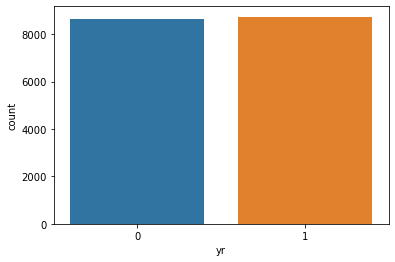

In [35]:

sns.countplot(x='yr', data=df_hour)

<AxesSubplot:xlabel='season', ylabel='count'>

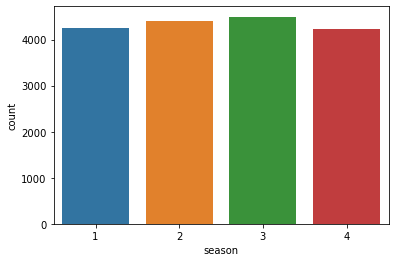

In [36]:
sns.countplot(x='season', data=df_hour)


<AxesSubplot:xlabel='holiday', ylabel='count'>

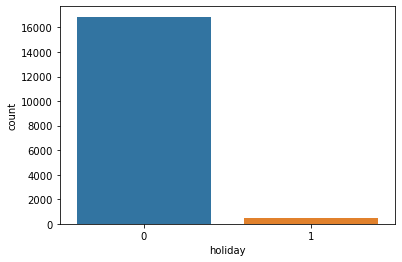

In [37]:
sns.countplot(x='holiday', data=df_hour)

<AxesSubplot:xlabel='mnth', ylabel='count'>

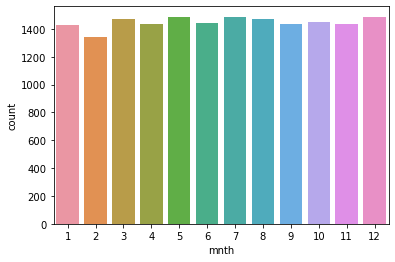

In [39]:
sns.countplot(x='mnth', data=df_hour)

In [43]:
df_day_spring = df_day[df_day['season'] == 2]
df_day_summer = df_day[df_day['season'] == 3]

(array([ 2.,  0.,  2.,  4.,  3.,  6.,  3.,  3.,  2.,  7.,  5.,  2., 11.,
         9., 14., 12., 14.,  9.,  6.,  6.,  5., 11., 11.,  8.,  9.,  4.,
         8.,  5.,  0.,  3.]),
 array([ 795.        , 1047.23333333, 1299.46666667, 1551.7       ,
        1803.93333333, 2056.16666667, 2308.4       , 2560.63333333,
        2812.86666667, 3065.1       , 3317.33333333, 3569.56666667,
        3821.8       , 4074.03333333, 4326.26666667, 4578.5       ,
        4830.73333333, 5082.96666667, 5335.2       , 5587.43333333,
        5839.66666667, 6091.9       , 6344.13333333, 6596.36666667,
        6848.6       , 7100.83333333, 7353.06666667, 7605.3       ,
        7857.53333333, 8109.76666667, 8362.        ]),
 <BarContainer object of 30 artists>)

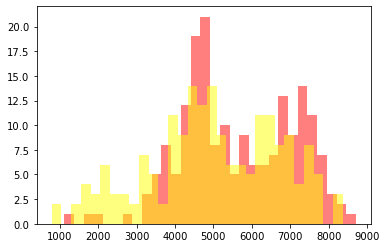

In [54]:
plt.hist(x=df_day_summer['cnt'], bins=30, alpha=0.5, color='red')
plt.hist(x=df_day_spring['cnt'], bins=30, alpha=0.5, color='yellow')

In [69]:
df_day_spring_weekday = df_day_spring[df_day_spring['weekday'] < 5]
df_day_summer_weekday = df_day_summer[df_day_summer['weekday'] < 5]

df_day_spring_weekdend = df_day_spring[df_day_spring['weekday'] >= 5]
df_day_summer_weekdend = df_day_summer[df_day_summer['weekday'] >= 5]


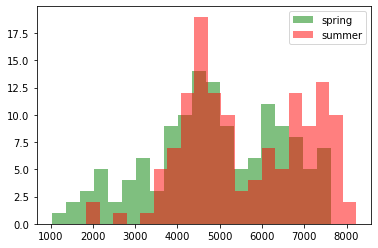

In [85]:
plt.hist(x=df_day_spring_weekday['cnt'], bins=20, alpha=0.5, color='green', label='spring')
plt.hist(x=df_day_summer_weekday['cnt'], bins=20, alpha=0.5, color='red', label='summer')
plt.legend()

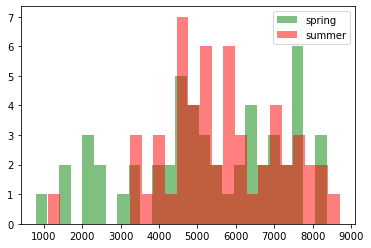

In [83]:
plt.hist(x='cnt', data=df_day_spring_weekdend, bins=25, alpha=0.5, color='green', label='spring')
plt.hist(x='cnt', data=df_day_summer_weekdend, bins=25, alpha=0.5, color='red', label='summer')
plt.legend()

In [90]:
df_evening = df_hour[df_hour['hr'] >= 15]
df_evening_summer = df_evening[df_evening['season'] == 3]
df_evening_spring = df_evening[df_evening['season'] == 2]

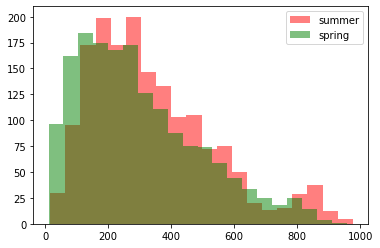

In [91]:
plt.hist(x='cnt', data=df_evening_summer, bins=20, alpha=0.5, color='red', label='summer')
plt.hist(x='cnt', data=df_evening_spring, bins=20, alpha=0.5, color='green', label='spring')
plt.legend()

In [93]:
df_evening_summer_weekday = df_evening_summer[df_evening_summer['weekday'] < 5]
df_evening_spring_weekday = df_evening_spring[df_evening_spring['weekday'] < 5]

df_evening_summer_weekend = df_evening_summer[df_evening_summer['weekday'] >= 5]
df_evening_spring_weekend = df_evening_spring[df_evening_spring['weekday'] >= 5]

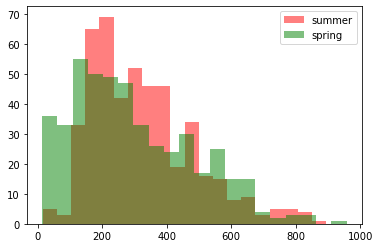

In [94]:
plt.hist(x='cnt', data=df_evening_summer_weekend, bins=20, alpha=0.5, color='red', label='summer')
plt.hist(x='cnt', data=df_evening_spring_weekend, bins=20, alpha=0.5, color='green', label='spring')
plt.legend()

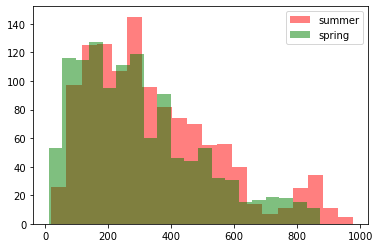

In [95]:
plt.hist(x='cnt', data=df_evening_summer_weekday, bins=20, alpha=0.5, color='red', label='summer')
plt.hist(x='cnt', data=df_evening_spring_weekday, bins=20, alpha=0.5, color='green', label='spring')
plt.legend()

In [ ]:
df

<AxesSubplot:xlabel='hr', ylabel='cnt'>

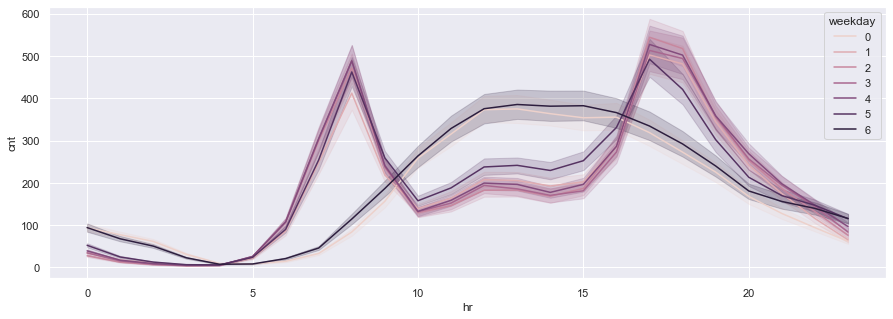

In [101]:
sns.set(rc={'figure.figsize':(15,5)})
sns.lineplot(data=df_hour, x='hr',y='cnt',hue='weekday')

## TO DO LIST

* Intro
* Code
* Mathematical deduction (LaTeX)
* Methods: Chi-Square, Likelihood-Ratio test, Goodness-of-fit
* Decide on which areas to deep-dive into (if any?)
* How many hypothesis tests to make? What can be drawn from them? (***be mindfull here!!***)
* Regressor models (Gaussian Linear regression if applicable? Will need data processing)
* Conclusion
* Drafting samples
* Plotting functions
* Outlier inspection
* Weekend vs Weekday